## Imports & Settings

In [7]:
from pathlib import Path
from time import time
import warnings
from collections import Counter
import logging
from ast import literal_eval as make_tuple
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
from gensim.models import Word2Vec, KeyedVectors
from gensim.models.word2vec import LineSentence
# import word2vec

In [8]:
pd.set_option('display.expand_frame_repr', False)
warnings.filterwarnings('ignore')
np.random.seed(42)

In [9]:
def format_time(t):
    m, s = divmod(t, 60)
    h, m = divmod(m, 60)
    return f'{h:02.0f}:{m:02.0f}:{s:02.0f}'

### Paths

In [11]:
sec_path = Path('data', 'sec-filings')
data_path = sec_path / 'data'
ngram_path = data_path / 'ngrams'
model_path = sec_path / 'models' /'baseline'

### Logging Setup

In [12]:
logging.basicConfig(
        filename=sec_path / 'logs' / 'word2vec.log',
        level=logging.DEBUG,
        format='%(asctime)s - %(name)s - %(levelname)s - %(message)s',
        datefmt='%H:%M:%S')

## word2vec

In [13]:
analogies_path = Path('data', 'analogies', 'analogies-en.txt')

### Set up Sentence Generator

In [6]:
NGRAMS = 2

To facilitate memory-efficient text ingestion, the LineSentence class creates a generator from individual sentences contained in the provided text file:

In [7]:
sentence_path = ngram_path  / f'ngrams_{NGRAMS}.txt'
sentences = LineSentence(sentence_path)

### Train word2vec Model

The [gensim.models.word2vec](https://radimrehurek.com/gensim/models/word2vec.html) class implements the skipgram and CBOW architectures introduced above. The notebook [word2vec](../03_word2vec.ipynb) contains additional implementation detail.

In [9]:
start = time()
model = Word2Vec(sentences,
                 sg=1,          # 1 for skip-gram; otherwise CBOW
                 hs=0,          # hierarchical softmax if 1, negative sampling if 0
                 size=300,      # Vector dimensionality
                 window=5,      # Max distance betw. current and predicted word
                 min_count=50,  # Ignore words with lower frequency
                 negative=15,    # noise word count for negative sampling
                 workers=8,     # no threads 
                 iter=1,        # no epochs = iterations over corpus
                 alpha=0.05,   # initial learning rate
                 min_alpha=0.0001 # final learning rate
                ) 
print('Duration:', format_time(time() - start))

Duration: 00:16:01


### Persist model & vectors

In [10]:
model.save((model_path / 'word2vec.model').as_posix())
model.wv.save((model_path / 'word_vectors.bin').as_posix())

### Load model and vectors

In [11]:
model = Word2Vec.load((model_path / 'word2vec.model').as_posix())

In [12]:
wv = KeyedVectors.load((model_path / 'word_vectors.bin').as_posix())

### Get vocabulary

In [13]:
vocab = []
for k, _ in model.wv.vocab.items():
    v_ = model.wv.vocab[k]
    vocab.append([k, v_.index, v_.count])

In [14]:
vocab = (pd.DataFrame(vocab, 
                     columns=['token', 'idx', 'count'])
         .sort_values('count', ascending=False))

In [15]:
vocab.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 50491 entries, 104 to 46372
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   token   50491 non-null  object
 1   idx     50491 non-null  int64 
 2   count   50491 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 1.5+ MB


In [16]:
vocab.head(10)

,token,idx,count
104,million,0,2340243
0,business,1,1700662
66,december,2,1513533
627,company,3,1490752
477,products,4,1368711
1071,net,5,1253343
145,market,6,1149048
380,including,7,1110482
381,sales,8,1098312
60,costs,9,1020383


In [17]:
vocab['count'].describe(percentiles=np.arange(.1, 1, .1)).astype(int)

count      50491
mean        5110
std        37525
min           50
10%           61
20%           78
30%          102
40%          137
50%          195
60%          300
70%          522
80%         1164
90%         4578
max      2340243
Name: count, dtype: int64

### Evaluate Analogies

In [18]:
def accuracy_by_category(acc, detail=True):
    results = [[c['section'], len(c['correct']), len(c['incorrect'])] for c in acc]
    results = pd.DataFrame(results, columns=['category', 'correct', 'incorrect'])
    results['average'] = results.correct.div(results[['correct', 'incorrect']].sum(1))
    if detail:
        print(results.sort_values('average', ascending=False))
    return results.loc[results.category=='total', ['correct', 'incorrect', 'average']].squeeze().tolist()

In [27]:
detailed_accuracy = model.wv.accuracy(analogies_path.as_posix(), case_insensitive=True)

In [28]:
summary = accuracy_by_category(detailed_accuracy)

                       category  correct  incorrect   average
10  gram6-nationality-adjective      361        451  0.444581
7             gram3-comparative      266        604  0.305747
9      gram5-present-participle      109        271  0.286842
12                 gram8-plural      141        365  0.278656
13           gram9-plural-verbs       81        225  0.264706
6                gram2-opposite       47        163  0.223810
14                        total     1585       5531  0.222737
5     gram1-adjective-to-adverb       67        239  0.218954
8             gram4-superlative       40        200  0.166667
11             gram7-past-tense      103        547  0.158462
2                 city-in-state      360       2164  0.142631
4                        family        2         28  0.066667
1                 capital-world        1         19  0.050000
3                      currency        5        147  0.032895
0      capital-common-countries        2        108  0.018182


In [19]:
def eval_analogies(w2v, max_vocab=15000):
    accuracy = w2v.wv.accuracy(analogies_path,
                               restrict_vocab=15000,
                               case_insensitive=True)
    return (pd.DataFrame([[c['section'],
                        len(c['correct']),
                        len(c['incorrect'])] for c in accuracy],
                      columns=['category', 'correct', 'incorrect'])
          .assign(average=lambda x: 
                  x.correct.div(x.correct.add(x.incorrect))))  

In [20]:
def total_accuracy(w2v):
    df = eval_analogies(w2v)
    return df.loc[df.category == 'total', ['correct', 'incorrect', 'average']].squeeze().tolist()

In [21]:
accuracy = eval_analogies(model)
accuracy

,category,correct,incorrect,average
0,capital-common-countries,0,12,0.000000
1,capital-world,0,0,NaN
2,city-in-state,123,549,0.183036
3,currency,4,48,0.076923
4,family,0,0,NaN
5,gram1-adjective-to-adverb,58,152,0.276190
6,gram2-opposite,18,72,0.200000
7,gram3-comparative,245,355,0.408333
8,gram4-superlative,20,70,0.222222
9,gram5-present-participle,93,179,0.341912


### Validate Vector Arithmetic

In [23]:
sims=model.wv.most_similar(positive=['iphone'], restrict_vocab=15000)
print(pd.DataFrame(sims, columns=['term', 'similarity']))

                  term  similarity
0                 ipad    0.795460
1              android    0.694014
2           smartphone    0.665732
3          smart_phone    0.656914
4          smartphones    0.635462
5  smartphones_tablets    0.631202
6           mobile_app    0.631132
7                  app    0.620540
8         smart_phones    0.610227
9              handset    0.604265


In [24]:
analogy = model.wv.most_similar(positive=['france', 'london'], 
                                negative=['paris'], 
                                restrict_vocab=15000)
print(pd.DataFrame(analogy, columns=['term', 'similarity']))

             term  similarity
0         germany    0.619907
1         finland    0.589645
2           italy    0.575894
3  united_kingdom    0.575391
4     netherlands    0.567589
5          sweden    0.566973
6         denmark    0.550692
7           spain    0.548837
8         belgium    0.544546
9         austria    0.538002


### Check similarity for random words

In [25]:
VALID_SET = 5  # Random set of words to get nearest neighbors for
VALID_WINDOW = 100  # Most frequent words to draw validation set from
valid_examples = np.random.choice(VALID_WINDOW, size=VALID_SET, replace=False)
similars = pd.DataFrame()

for id in sorted(valid_examples):
    word = vocab.loc[id, 'token']
    similars[word] = [s[0] for s in model.wv.most_similar(word)]
similars

,support,staff,cycle,monthly,expansion
0,supporting,personnel,cycles,month,expansions
1,supports,team,organic_rankine,biweekly,expand
2,supported,teams,riverton,bi_weekly,expanding
3,helpdesk,hiring,igcc,weekly,growth
4,help_desk,staffed,turbine_generator,semiannual,expanded
5,fortiguard,consultants,repeats,arrears,cajun_sibon
6,sustainment,technicians,hospital_stays,monthly_installments,organic_growth
7,shoretel_sky,trained,lengthens,daily,lay_foundation
8,allregs,liaison,combustion_turbines,sent_disclosing,debottlenecking
9,expeditionary_airlift,salespeople,mechanical_ventilation,semiannually,nava_brewery


## Continue Training

In [32]:
(pd.DataFrame(accuracies, 
             columns=['correct', 'wrong', 'average'])
 .to_csv(model_path / 'accuracies.csv', index=False))

In [ ]:
accuracies = [summary]
best_accuracy = summary[-1]
for i in range(1, 20):
    start = time()
    model.train(sentences, epochs=1, total_examples=model.corpus_count)
    detailed_accuracy = model.wv.accuracy(analogies_path)
    accuracies.append(accuracy_by_category(detailed_accuracy, detail=False))
    print(f'{i:02} | Duration: {format_time(time() - start)} | Accuracy: {accuracies[-1][-1]:.2%} ')
    if accuracies[-1][-1] > best_accuracy:
        model.save((model_path / f'word2vec_{i:02}.model').as_posix())
        model.wv.save((model_path / f'word_vectors_{i:02}.bin').as_posix())
        best_accuracy = accuracies[-1][-1]
    (pd.DataFrame(accuracies, 
                 columns=['correct', 'wrong', 'average'])
     .to_csv(model_path / 'accuracies.csv', index=False))
model.wv.save((model_path / 'word_vectors_final.bin').as_posix())

In [37]:
best_model = Word2Vec.load((model_path / 'word2vec_04.model').as_posix())

In [39]:
detailed_accuracy = best_model.wv.accuracy(analogies_path.as_posix(), case_insensitive=True)

In [40]:
summary = accuracy_by_category(detailed_accuracy)
print('Base Accuracy: Correct {:,.0f} | Wrong {:,.0f} | Avg {:,.2%}\n'.format(*summary))

                       category  correct  incorrect   average
10  gram6-nationality-adjective      399        413  0.491379
12                 gram8-plural      201        305  0.397233
7             gram3-comparative      314        556  0.360920
9      gram5-present-participle      120        260  0.315789
14                        total     2130       4986  0.299325
13           gram9-plural-verbs       91        215  0.297386
2                 city-in-state      706       1818  0.279715
6                gram2-opposite       43        167  0.204762
5     gram1-adjective-to-adverb       60        246  0.196078
11             gram7-past-tense      124        526  0.190769
8             gram4-superlative       45        195  0.187500
0      capital-common-countries       13         97  0.118182
4                        family        3         27  0.100000
3                      currency       11        141  0.072368
1                 capital-world        0         20  0.000000
Base Acc

In [42]:
cat_dict = {'capital-common-countries':'Capitals',
            'capital-world':'Capitals RoW',
            'city-in-state':'City-State',
            'currency':'Currency',
            'family':'Famliy',
            'gram1-adjective-to-adverb':'Adj-Adverb',
            'gram2-opposite':'Opposite',
            'gram3-comparative':'Comparative',
            'gram4-superlative':'Superlative',
            'gram5-present-participle':'Pres. Part.',
            'gram6-nationality-adjective':'Nationality',
            'gram7-past-tense':'Past Tense',
            'gram8-plural':'Plural',
            'gram9-plural-verbs':'Plural Verbs',
            'total':'Total'}

In [43]:
results = [[c['section'], len(c['correct']), len(c['incorrect'])] for c in detailed_accuracy]
results = pd.DataFrame(results, columns=['category', 'correct', 'incorrect'])
results['category'] = results.category.map(cat_dict)
results['average'] = results.correct.div(results[['correct', 'incorrect']].sum(1))
results = results.rename(columns=str.capitalize).set_index('Category')
total = results.loc['Total']
results = results.drop('Total')

In [44]:
most_sim = best_model.wv.most_similar(positive=['woman', 'king'], negative=['man'], topn=20)
pd.DataFrame(most_sim, columns=['token', 'similarity'])

,token,similarity
0,sarepta_therapeutics,0.369468
1,scent,0.369441
2,jennifer,0.359323
3,scholl,0.355960
4,vertex_pharmaceuticals,0.355397
5,glen,0.354979
6,women,0.354705
7,fauquier,0.354091
8,rosenberg,0.351302
9,miracle,0.350760


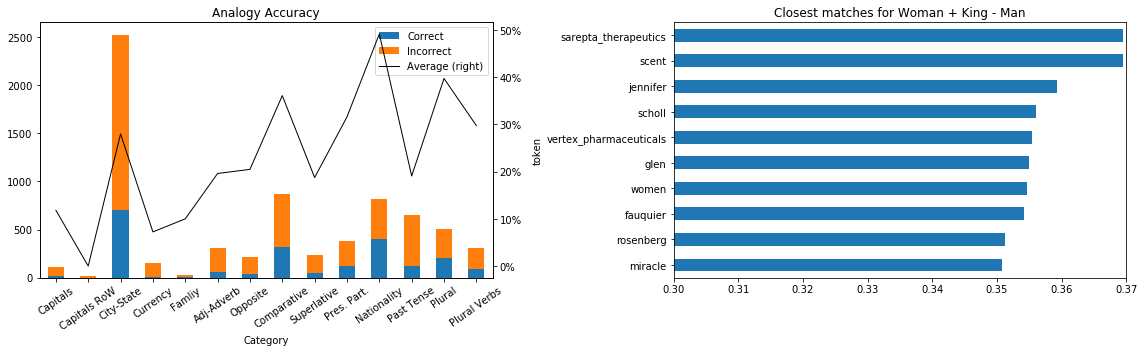

In [50]:
fig, axes = plt.subplots(figsize=(16, 5), ncols=2)

axes[0] = results.loc[:, ['Correct', 'Incorrect']].plot.bar(stacked=True, ax=axes[0]
                                                           , title='Analogy Accuracy')
ax1 = results.loc[:, ['Average']].plot(ax=axes[0], secondary_y=True, lw=1, c='k', rot=35)
ax1.yaxis.set_major_formatter(FuncFormatter(lambda y, _: '{:.0%}'.format(y)))

(pd.DataFrame(most_sim, columns=['token', 'similarity'])
 .set_index('token').similarity
 .sort_values().tail(10).plot.barh(xlim=(.3, .37), ax=axes[1], title='Closest matches for Woman + King - Man'))
fig.tight_layout()
# fig.savefig('figures/w2v_evaluation', dpi=300);